In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
#from builtins import range
from builtins import object
from __future__ import print_function, division
from future import standard_library
standard_library.install_aliases()
from past.builtins import xrange
from six.moves import cPickle as pickle
from random import randrange
from time import time
import os
import platform

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Some Useful Functions for Forward and Backward passes

In [2]:
def affine_forward(x, w, b):
    """Computes the forward pass for an affine (fully connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    
    x_row = x.reshape(x.shape[0], -1) #shape (N, D)
    
    out = x_row@w + b #shape (N, M)
    cache = (x, w, b)
    
    return out, cache

def affine_backward(dout, cache):
    """Computes the backward pass for an affine (fully connected) layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None

    x_row = x.reshape(x.shape[0], -1) #shape (N, D)
    dw = x_row.T@dout
    db = np.sum(dout, axis=0)
    dx = (dout@w.T).reshape(x.shape[0], *x.shape[1:])

    return dx, dw, db

def relu_forward(x):
    """Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None

    out = np.maximum(0, x)
    cache = x
    
    return out, cache

def relu_backward(dout, cache):
    """Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    dx = dout*(x > 0)

    return dx

def softmax_loss(x, y):
    """Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and 0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    loss, dx = None, None

    num_train = x.shape[0]
    num_classes = x.shape[1]
    fs = x     
    fs = fs - fs.max(axis = 1, keepdims = True) #exponents that are numerically stable
    probs = np.exp(fs)/np.sum(np.exp(fs), axis = 1, keepdims = True)
    loss = -np.sum(np.log(probs[range(num_train), y]))
    loss = loss/num_train

    probs[range(num_train), y] -= 1
    dx = probs/num_train

    return loss, dx

def batchnorm_forward(x, gamma, beta, bn_param):
    """Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the mean and variance of each feature, and these averages are used to normalize
    data at test-time.

    At each timestep we update the running averages for mean and variance using an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var


    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param["mode"]
    eps = bn_param.get("eps", 1e-5)
    momentum = bn_param.get("momentum", 0.9)

    N, D = x.shape
    running_mean = bn_param.get("running_mean", np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get("running_var", np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == "train":

        mu = x.mean(axis=0)        
        var = x.var(axis=0)       
        std = np.sqrt(var + eps)   
        x_hat = (x - mu) / std     # standartized x
        out = gamma * x_hat + beta # scaled and shifted x_hat

        shape = bn_param.get('shape', (N, D))              # reshape used in backprop
        axis = bn_param.get('axis', 0)                     # axis to sum used in backprop
        cache = x, mu, var, std, gamma, x_hat, shape, axis # save for backprop

        if axis == 0:                                                    
            running_mean = momentum * running_mean + (1 - momentum) * mu # update overall mean
            running_var = momentum * running_var + (1 - momentum) * var  # update overall variance

    elif mode == "test":

        x_hat = (x - running_mean) / np.sqrt(running_var + eps)
        out = gamma * x_hat + beta

    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param["running_mean"] = running_mean
    bn_param["running_var"] = running_var

    return out, cache


def batchnorm_backward(dout, cache):
    """Backward pass for batch normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    
    # original paper (https://arxiv.org/abs/1502.03167)
    # https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html
    
    x, mu, var, std, gamma, x_hat, shape, axis = cache

    dbeta = dout.reshape(shape, order='F').sum(axis)            # derivative w.r.t. beta
    dgamma = (dout * x_hat).reshape(shape, order='F').sum(axis) # derivative w.r.t. gamma

    dx_hat = dout * gamma                                       # derivative w.r.t. x_hat
    dstd = -np.sum(dx_hat * (x-mu), axis=0) / (std**2)          # derivative w.r.t. std
    dvar = 0.5 * dstd / std                                     # derivative w.r.t. var
    dx1 = dx_hat / std + 2 * (x-mu) * dvar / len(dout)          # partial derivative w.r.t. dx
    dmu = -np.sum(dx1, axis=0)                                  # derivative w.r.t. mu
    dx2 = dmu / len(dout)                                       # partial derivative w.r.t. dx
    dx = dx1 + dx2                                              # full derivative w.r.t. x

    return dx, dgamma, dbeta


def batchnorm_backward_alt(dout, cache):
    """Alternative backward pass for batch normalization.

    Inputs / outputs: Same as batchnorm_backward
    """
    dx, dgamma, dbeta = None, None, None

    _, _, _, std, gamma, x_hat, shape, axis = cache # expand cache
    S = lambda x: x.sum(axis=0)                     # helper function
    
    dbeta = dout.reshape(shape, order='F').sum(axis)            # derivative w.r.t. beta
    dgamma = (dout * x_hat).reshape(shape, order='F').sum(axis) # derivative w.r.t. gamma
    
    dx = dout * gamma / (len(dout) * std)          # temporarily initialize scale value
    dx = len(dout)*dx  - S(dx*x_hat)*x_hat - S(dx) # derivative w.r.t. unnormalized x

    return dx, dgamma, dbeta


def layernorm_forward(x, gamma, beta, ln_param):
    """Forward pass for layer normalization.

    During both training and test-time, the incoming data is normalized per data-point,
    before being scaled by gamma and beta parameters identical to that of batch normalization.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - ln_param: Dictionary with the following keys:
        - eps: Constant for numeric stability

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    out, cache = None, None
    eps = ln_param.get("eps", 1e-5)
    
    bn_param = {"mode": "train", "axis": 1, **ln_param} # same as batchnorm in train mode + over which axis to sum for grad
    [gamma, beta] = np.atleast_2d(gamma, beta)          # assure 2D to perform transpose

    out, cache = batchnorm_forward(x.T, gamma.T, beta.T, bn_param) # same as batchnorm
    out = out.T                                                    # transpose back

    return out, cache


def layernorm_backward(dout, cache):
    """Backward pass for layer normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from layernorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    
    dx, dgamma, dbeta = None, None, None

    dx, dgamma, dbeta = batchnorm_backward_alt(dout.T, cache) # same as batchnorm backprop
    dx = dx.T                                                 # transpose back dx

    return dx, dgamma, dbeta


def dropout_forward(x, dropout_param):
    """Forward pass for inverted dropout.

    different from the vanilla version of dropout.
    Here, p is the probability of keeping a neuron output, as opposed to the probability of dropping a neuron output.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We keep each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not
        in real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.
    """
    p, mode = dropout_param["p"], dropout_param["mode"]
    if "seed" in dropout_param:
        np.random.seed(dropout_param["seed"])

    mask = None
    out = None

    if mode == "train":
        mask = np.random.choice([0, 1], size=x.shape, p=[1-p, p])/p
        out = x*mask

    elif mode == "test":
        out = x
    
    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache


def dropout_backward(dout, cache):
    """Backward pass for inverted dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param["mode"]

    dx = None
    if mode == "train":
        dx = dout*mask

    elif mode == "test":
        dx = dout
    return dx

def conv_forward_naive(x, w, b, conv_param):
    """A naive implementation of the forward pass for a convolutional layer.

    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width WW.

    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input.

    During padding, 'pad' zeros should be placed symmetrically (i.e equally on both sides)
    along the height and width axes of the input. Be careful not to modfiy the original
    input x directly.

    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    - cache: (x, w, b, conv_param)
    """
    out = None

    N, C, H, W = x.shape
    F, C, HH, WW = w.shape
    S = conv_param['stride']
    P = conv_param['pad']

    # Add padding to each image
    x_pad = np.pad(x, ((0,), (0,), (P,), (P,)), 'constant')
    # Size of the output
    Hh = 1 + (H + 2 * P - HH) // S
    Hw = 1 + (W + 2 * P - WW) // S

    out = np.zeros((N, F, Hh, Hw))

    for n in range(N):  # First, iterate over all the images
        for f in range(F):  # Second, iterate over all the kernels
            for k in range(Hh):
                for l in range(Hw):
                    out[n, f, k, l] = np.sum(x_pad[n, :, (k * S):(k * S + HH), (l * S):(l * S + WW)] * w[f, :]) + b[f]

    cache = (x, w, b, conv_param)
    return out, cache


def conv_backward_naive(dout, cache):
    """A naive implementation of the backward pass for a convolutional layer.

    Inputs:
    - dout: Upstream derivatives.
    - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive

    Returns a tuple of:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    """
    dx, dw, db = None, None, None

    x, w, b, conv_param = cache
    P = conv_param['pad']
    x_pad = np.pad(x, ((0,), (0,), (P,), (P,)), 'constant')

    N, C, H, W = x.shape
    F, C, HH, WW = w.shape
    N, F, Hh, Hw = dout.shape
    S = conv_param['stride']

    # For dw: Size (F, C,HH,WW)
    dw = np.zeros((F, C, HH, WW))
    for fprime in range(F):
        for cprime in range(C):
            for i in range(HH):
                for j in range(WW):
                    sub_xpad = x_pad[:, cprime, i:(i + Hh * S):S, j:(j + Hw * S):S]
                    dw[fprime, cprime, i, j] = np.sum(dout[:, fprime, :, :] * sub_xpad)

    # For db : Size (F,)
    db = np.zeros((F))
    for fprime in range(F):
        db[fprime] = np.sum(dout[:, fprime, :, :])

    dx = np.zeros((N, C, H, W))
    for nprime in range(N):
        for i in range(H):
            for j in range(W):
                for f in range(F):
                    for k in range(Hh):
                        for l in range(Hw):
                            mask1 = np.zeros_like(w[f, :, :, :])
                            mask2 = np.zeros_like(w[f, :, :, :])
                            if (i + P - k * S) < HH and (i + P - k * S) >= 0:
                                mask1[:, i + P - k * S, :] = 1.0
                            if (j + P - l * S) < WW and (j + P - l * S) >= 0:
                                mask2[:, :, j + P - l * S] = 1.0
                            w_masked = np.sum( w[f, :, :, :] * mask1 * mask2, axis=(1, 2))
                            dx[nprime, :, i, j] += dout[nprime, f, k, l] * w_masked

    return dx, dw, db


def max_pool_forward_naive(x, pool_param):
    """A naive implementation of the forward pass for a max-pooling layer.

    Inputs:
    - x: Input data, of shape (N, C, H, W)
    - pool_param: dictionary with the following keys:
      - 'pool_height': The height of each pooling region
      - 'pool_width': The width of each pooling region
      - 'stride': The distance between adjacent pooling regions

    No padding is necessary here, eg you can assume:
      - (H - pool_height) % stride == 0
      - (W - pool_width) % stride == 0

    Returns a tuple of:
    - out: Output data, of shape (N, C, H', W') where H' and W' are given by
      H' = 1 + (H - pool_height) / stride
      W' = 1 + (W - pool_width) / stride
    - cache: (x, pool_param)
    """
    out = None

    Hp = pool_param['pool_height']
    Wp = pool_param['pool_width']
    S = pool_param['stride']
    N, C, H, W = x.shape
    H1 = (H - Hp) // S + 1
    W1 = (W - Wp) // S + 1

    out = np.zeros((N, C, H1, W1))
    for n in range(N):
        for c in range(C):
            for k in range(H1):
                for l in range(W1):
                    out[n, c, k, l] = np.max(
                        x[n, c, (k * S):(k * S + Hp), (l * S):(l * S + Wp)])
                    
    cache = (x, pool_param)
    return out, cache

def max_pool_backward_naive(dout, cache):
    """A naive implementation of the backward pass for a max-pooling layer.

    Inputs:
    - dout: Upstream derivatives
    - cache: A tuple of (x, pool_param) as in the forward pass.

    Returns:
    - dx: Gradient with respect to x
    """
    dx = None

    x, pool_param = cache
    Hp = pool_param['pool_height']
    Wp = pool_param['pool_width']
    S = pool_param['stride']
    N, C, H, W = x.shape
    H1 = (H - Hp) // S + 1
    W1 = (W - Wp) // S + 1

    dx = np.zeros((N, C, H, W))
    for nprime in range(N):
        for cprime in range(C):
            for k in range(H1):
                for l in range(W1):
                    x_pooling = x[nprime, cprime, (k*S):(k*S + Hp), (l*S):(l*S + Wp)]
                    maxi = np.max(x_pooling)
                    x_mask = x_pooling == maxi
                    dx[nprime, cprime, (k*S):(k*S + Hp), (l*S):(l*S + Wp)] += dout[nprime, cprime, k, l] * x_mask

    return dx

def spatial_batchnorm_forward(x, gamma, beta, bn_param):
    """Computes the forward pass for spatial batch normalization.

    Inputs:
    - x: Input data of shape (N, C, H, W)
    - gamma: Scale parameter, of shape (C,)
    - beta: Shift parameter, of shape (C,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance. momentum=0 means that
        old information is discarded completely at every time step, while
        momentum=1 means that new information is never incorporated. The
        default of momentum=0.9 should work well in most situations.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: Output data, of shape (N, C, H, W)
    - cache: Values needed for the backward pass
    """
    out, cache = None, None

    N, C, H, W = x.shape                                     # input dims
    x = np.moveaxis(x, 1, -1).reshape(-1, C)                 # swap axes to use vanilla batchnorm
    out, cache = batchnorm_forward(x, gamma, beta, bn_param) # perform vanilla batchnorm
    out = np.moveaxis(out.reshape(N, H, W, C), -1, 1)

    return out, cache


def spatial_batchnorm_backward(dout, cache):
    """Computes the backward pass for spatial batch normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, C, H, W)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient with respect to inputs, of shape (N, C, H, W)
    - dgamma: Gradient with respect to scale parameter, of shape (C,)
    - dbeta: Gradient with respect to shift parameter, of shape (C,)
    """
    dx, dgamma, dbeta = None, None, None

    N, C, H, W = dout.shape                             # upstream dims
    dout = np.moveaxis(dout, 1, -1).reshape(-1, C)      # swap axes to use vanilla batchnorm backprop
    dx, dgamma, dbeta = batchnorm_backward(dout, cache) # perform vanilla batchnorm backprop
    dx = np.moveaxis(dx.reshape(N, H, W, C), -1, 1)     # swap back axes for the gradient of dx

    return dx, dgamma, dbeta


def spatial_groupnorm_forward(x, gamma, beta, G, gn_param):
    """Computes the forward pass for spatial group normalization.
    
    In contrast to layer normalization, group normalization splits each entry in the data into G
    contiguous pieces, which it then normalizes independently. Per-feature shifting and scaling
    are then applied to the data, in a manner identical to that of batch normalization and layer
    normalization.

    Inputs:
    - x: Input data of shape (N, C, H, W)
    - gamma: Scale parameter, of shape (1, C, 1, 1)
    - beta: Shift parameter, of shape (1, C, 1, 1)
    - G: Integer mumber of groups to split into, should be a divisor of C
    - gn_param: Dictionary with the following keys:
      - eps: Constant for numeric stability

    Returns a tuple of:
    - out: Output data, of shape (N, C, H, W)
    - cache: Values needed for the backward pass
    """
    out, cache = None, None
    eps = gn_param.get("eps", 1e-5)

    N, C, H, W = x.shape                                            # input dims
    ln_param = {"shape":(W, H, C, N), "axis":(0, 1, 3), **gn_param} # params to reuse batchnorm method
    
    x = x.reshape(N*G, -1) # reshape x to use vanilla layernorm
    gamma = np.tile(gamma, (N, 1, H, W)).reshape(N*G, -1)     # reshape gamma to use vanilla layernorm
    beta = np.tile(beta, (N, 1, H, W)).reshape(N*G, -1)       # reshape beta to use vanilla layernorm

    out, cache = layernorm_forward(x, gamma, beta, ln_param)  # perform vanilla layernorm
    out = out.reshape(N, C, H, W)                             # reshape back the output
    cache = (G, cache)                                      # cache involves G

    return out, cache


def spatial_groupnorm_backward(dout, cache):
    """Computes the backward pass for spatial group normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, C, H, W)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient with respect to inputs, of shape (N, C, H, W)
    - dgamma: Gradient with respect to scale parameter, of shape (1, C, 1, 1)
    - dbeta: Gradient with respect to shift parameter, of shape (1, C, 1, 1)
    """
    dx, dgamma, dbeta = None, None, None

    G, cache = cache                                    # expand cache
    N, C, H, W = dout.shape                             # upstream dims
    dout = dout.reshape(N*G, -1)                        # reshape to use vanilla layernorm backprop

    dx, dgamma, dbeta = layernorm_backward(dout, cache) # perform vanilla layernorm backprop
    dx = dx.reshape(N, C, H, W)                         # reshape back dx
    dbeta = dbeta[None, :, None, None]                  # reshape back dbeta
    dgamma = dgamma[None, :, None, None]                # reshape back dgamma

    return dx, dgamma, dbeta


def generic_forward(x, w, b, gamma=None, beta=None, bn_param=None, dropout_param=None, last=False):
    """Convenience layer that performs an affine transform, a batch/layer normalization if needed, a ReLU, and dropout if needed.
    
    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer
    - gamma, beta: Scale and shift params for the batch normalization
    - bn_param: Dictionary of required BN parameters
    - dropout_param: Dictionary of required Dropout parameters
    - last: Indicates wether to perform just affine forward
    Returns a tuple of:
    - out: Output from the ReLU or Dropout
    - cache: Object to give to the backward pass
    """
    
    bn_cache, ln_cache, relu_cache, dropout_cache = None, None, None, None # Initialize optional caches to None
    out, fc_cache = affine_forward(x, w, b) # Affine forward is a must

    # If the the layer is not last
    if not last:
        # If it has normalization layer we normalize outputs: if it bn_param has mode (train | test), it's batchnorm, otherwise, it's layernorm
        if bn_param is not None:
            if 'mode' in bn_param:
                out, bn_cache = batchnorm_forward(out, gamma, beta, bn_param)
            else:
                out, ln_cache = layernorm_forward(out, gamma, beta, bn_param)

        # Pass the outputs through non-linearity
        out, relu_cache = relu_forward(out) # perform relu

        # Use dropout if we are given its parameters
        if dropout_param is not None:
            out, dropout_cache = dropout_forward(out, dropout_param)
    
    # Prepare cache for backward pass
    cache = fc_cache, bn_cache, ln_cache, relu_cache, dropout_cache

    return out, cache

def generic_backward(dout, cache):
    """Backward pass for the affine-bn/ln?-relu-dropout? convenience layer.
    """
    # Init norm params to None
    dgamma, dbeta = None, None

    # Get the prapared caches from the forward pass
    fc_cache, bn_cache, ln_cache, relu_cache, dropout_cache = cache

    # If dropout was performed
    if dropout_cache is not None:
        dout = dropout_backward(dout, dropout_cache)
    
    # If relu was performed
    if relu_cache is not None:
        dout = relu_backward(dout, relu_cache)

    # If norm was performed
    if bn_cache is not None:
        dout, dgamma, dbeta = batchnorm_backward(dout, bn_cache)
    elif ln_cache is not None:
        dout, dgamma, dbeta = layernorm_backward(dout, ln_cache)
    
    # Affine backward is a must
    dx, dw, db = affine_backward(dout, fc_cache)

    return dx, dw, db, dgamma, dbeta

def affine_relu_forward(x, w, b):
    """Convenience layer that performs an affine transform followed by a ReLU.

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache

def affine_relu_backward(dout, cache):
    """Backward pass for the affine-relu convenience layer.
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)
    return dx, dw, db

def conv_relu_forward(x, w, b, conv_param):
    """A convenience layer that performs a convolution followed by a ReLU.

    Inputs:
    - x: Input to the convolutional layer
    - w, b, conv_param: Weights and parameters for the convolutional layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, conv_cache = conv_forward_fast(x, w, b, conv_param)
    out, relu_cache = relu_forward(a)
    cache = (conv_cache, relu_cache)
    return out, cache


def conv_relu_backward(dout, cache):
    """Backward pass for the conv-relu convenience layer.
    """
    conv_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = conv_backward_fast(da, conv_cache)
    return dx, dw, db


def conv_bn_relu_forward(x, w, b, gamma, beta, conv_param, bn_param):
    """Convenience layer that performs a convolution, a batch normalization, and a ReLU.

    Inputs:
    - x: Input to the convolutional layer
    - w, b, conv_param: Weights and parameters for the convolutional layer
    - pool_param: Parameters for the pooling layer
    - gamma, beta: Arrays of shape (D2,) and (D2,) giving scale and shift
      parameters for batch normalization.
    - bn_param: Dictionary of parameters for batch normalization.

    Returns a tuple of:
    - out: Output from the pooling layer
    - cache: Object to give to the backward pass
    """
    a, conv_cache = conv_forward_fast(x, w, b, conv_param)
    an, bn_cache = spatial_batchnorm_forward(a, gamma, beta, bn_param)
    out, relu_cache = relu_forward(an)
    cache = (conv_cache, bn_cache, relu_cache)
    return out, cache


def conv_bn_relu_backward(dout, cache):
    """Backward pass for the conv-bn-relu convenience layer.
    """
    conv_cache, bn_cache, relu_cache = cache
    dan = relu_backward(dout, relu_cache)
    da, dgamma, dbeta = spatial_batchnorm_backward(dan, bn_cache)
    dx, dw, db = conv_backward_fast(da, conv_cache)
    return dx, dw, db, dgamma, dbeta


def conv_relu_pool_forward(x, w, b, conv_param, pool_param):
    """Convenience layer that performs a convolution, a ReLU, and a pool.

    Inputs:
    - x: Input to the convolutional layer
    - w, b, conv_param: Weights and parameters for the convolutional layer
    - pool_param: Parameters for the pooling layer

    Returns a tuple of:
    - out: Output from the pooling layer
    - cache: Object to give to the backward pass
    """
    a, conv_cache = conv_forward_fast(x, w, b, conv_param)
    s, relu_cache = relu_forward(a)
    out, pool_cache = max_pool_forward_fast(s, pool_param)
    cache = (conv_cache, relu_cache, pool_cache)
    return out, cache


def conv_relu_pool_backward(dout, cache):
    """Backward pass for the conv-relu-pool convenience layer.
    """
    conv_cache, relu_cache, pool_cache = cache
    ds = max_pool_backward_fast(dout, pool_cache)
    da = relu_backward(ds, relu_cache)
    dx, dw, db = conv_backward_fast(da, conv_cache)
    return dx, dw, db

### Fast layers for CNN

In [3]:
def get_im2col_indices(x_shape, field_height, field_width, padding=1, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    assert (H + 2 * padding - field_height) % stride == 0
    assert (W + 2 * padding - field_height) % stride == 0
    out_height = (H + 2 * padding - field_height) / stride + 1
    out_width = (W + 2 * padding - field_width) / stride + 1

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)


def im2col_indices(x, field_height, field_width, padding=1, stride=1):
    """ An implementation of im2col based on some fancy indexing """
    # Zero-pad the input
    p = padding
    x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode="constant")

    k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding, stride)

    cols = x_padded[:, k, i, j]
    C = x.shape[1]
    cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
    return cols


def col2im_indices(cols, x_shape, field_height=3, field_width=3, padding=1, stride=1):
    """ An implementation of col2im based on fancy indexing and np.add.at """
    N, C, H, W = x_shape
    H_padded, W_padded = H + 2 * padding, W + 2 * padding
    x_padded = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
    k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding, stride)
    cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
    cols_reshaped = cols_reshaped.transpose(2, 0, 1)
    np.add.at(x_padded, (slice(None), k, i, j), cols_reshaped)
    if padding == 0:
        return x_padded
    return x_padded[:, :, padding:-padding, padding:-padding]


def conv_forward_im2col(x, w, b, conv_param):
    """
    A fast implementation of the forward pass for a convolutional layer
    based on im2col and col2im.
    """
    N, C, H, W = x.shape
    num_filters, _, filter_height, filter_width = w.shape
    stride, pad = conv_param["stride"], conv_param["pad"]

    # Check dimensions
    assert (W + 2 * pad - filter_width) % stride == 0, "width does not work"
    assert (H + 2 * pad - filter_height) % stride == 0, "height does not work"

    # Create output
    out_height = (H + 2 * pad - filter_height) // stride + 1
    out_width = (W + 2 * pad - filter_width) // stride + 1
    out = np.zeros((N, num_filters, out_height, out_width), dtype=x.dtype)

    # x_cols = im2col_indices(x, w.shape[2], w.shape[3], pad, stride)
    x_cols = im2col_cython(x, w.shape[2], w.shape[3], pad, stride)
    res = w.reshape((w.shape[0], -1)).dot(x_cols) + b.reshape(-1, 1)

    out = res.reshape(w.shape[0], out.shape[2], out.shape[3], x.shape[0])
    out = out.transpose(3, 0, 1, 2)

    cache = (x, w, b, conv_param, x_cols)
    return out, cache


def conv_forward_strides(x, w, b, conv_param):
    N, C, H, W = x.shape
    F, _, HH, WW = w.shape
    stride, pad = conv_param["stride"], conv_param["pad"]

    # Check dimensions
    # assert (W + 2 * pad - WW) % stride == 0, 'width does not work'
    # assert (H + 2 * pad - HH) % stride == 0, 'height does not work'

    # Pad the input
    p = pad
    x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode="constant")

    # Figure out output dimensions
    H += 2 * pad
    W += 2 * pad
    out_h = (H - HH) // stride + 1
    out_w = (W - WW) // stride + 1

    # Perform an im2col operation by picking clever strides
    shape = (C, HH, WW, N, out_h, out_w)
    strides = (H * W, W, 1, C * H * W, stride * W, stride)
    strides = x.itemsize * np.array(strides)
    x_stride = np.lib.stride_tricks.as_strided(x_padded, shape=shape, strides=strides)
    x_cols = np.ascontiguousarray(x_stride)
    x_cols.shape = (C * HH * WW, N * out_h * out_w)

    # Now all our convolutions are a big matrix multiply
    res = w.reshape(F, -1).dot(x_cols) + b.reshape(-1, 1)

    # Reshape the output
    res.shape = (F, N, out_h, out_w)
    out = res.transpose(1, 0, 2, 3)

    # Be nice and return a contiguous array
    # The old version of conv_forward_fast doesn't do this, so for a fair
    # comparison we won't either
    out = np.ascontiguousarray(out)

    cache = (x, w, b, conv_param, x_cols)
    return out, cache


def conv_backward_strides(dout, cache):
    x, w, b, conv_param, x_cols = cache
    stride, pad = conv_param["stride"], conv_param["pad"]

    N, C, H, W = x.shape
    F, _, HH, WW = w.shape
    _, _, out_h, out_w = dout.shape

    db = np.sum(dout, axis=(0, 2, 3))

    dout_reshaped = dout.transpose(1, 0, 2, 3).reshape(F, -1)
    dw = dout_reshaped.dot(x_cols.T).reshape(w.shape)

    dx_cols = w.reshape(F, -1).T.dot(dout_reshaped)
    dx_cols.shape = (C, HH, WW, N, out_h, out_w)
    dx = col2im_6d_cython(dx_cols, N, C, H, W, HH, WW, pad, stride)

    return dx, dw, db


def conv_backward_im2col(dout, cache):
    """
    A fast implementation of the backward pass for a convolutional layer
    based on im2col and col2im.
    """
    x, w, b, conv_param, x_cols = cache
    stride, pad = conv_param["stride"], conv_param["pad"]

    db = np.sum(dout, axis=(0, 2, 3))

    num_filters, _, filter_height, filter_width = w.shape
    dout_reshaped = dout.transpose(1, 2, 3, 0).reshape(num_filters, -1)
    dw = dout_reshaped.dot(x_cols.T).reshape(w.shape)

    dx_cols = w.reshape(num_filters, -1).T.dot(dout_reshaped)
    # dx = col2im_indices(dx_cols, x.shape, filter_height, filter_width, pad, stride)
    dx = col2im_cython(
        dx_cols,
        x.shape[0],
        x.shape[1],
        x.shape[2],
        x.shape[3],
        filter_height,
        filter_width,
        pad,
        stride,
    )

    return dx, dw, db


conv_forward_fast = conv_forward_strides
conv_backward_fast = conv_backward_strides


def max_pool_forward_fast(x, pool_param):
    """
    A fast implementation of the forward pass for a max pooling layer.

    This chooses between the reshape method and the im2col method. If the pooling
    regions are square and tile the input image, then we can use the reshape
    method which is very fast. Otherwise we fall back on the im2col method, which
    is not much faster than the naive method.
    """
    N, C, H, W = x.shape
    pool_height, pool_width = pool_param["pool_height"], pool_param["pool_width"]
    stride = pool_param["stride"]

    same_size = pool_height == pool_width == stride
    tiles = H % pool_height == 0 and W % pool_width == 0
    if same_size and tiles:
        out, reshape_cache = max_pool_forward_reshape(x, pool_param)
        cache = ("reshape", reshape_cache)
    else:
        out, im2col_cache = max_pool_forward_im2col(x, pool_param)
        cache = ("im2col", im2col_cache)
    return out, cache


def max_pool_backward_fast(dout, cache):
    """
    A fast implementation of the backward pass for a max pooling layer.

    This switches between the reshape method an the im2col method depending on
    which method was used to generate the cache.
    """
    method, real_cache = cache
    if method == "reshape":
        return max_pool_backward_reshape(dout, real_cache)
    elif method == "im2col":
        return max_pool_backward_im2col(dout, real_cache)
    else:
        raise ValueError('Unrecognized method "%s"' % method)


def max_pool_forward_reshape(x, pool_param):
    """
    A fast implementation of the forward pass for the max pooling layer that uses
    some clever reshaping.

    This can only be used for square pooling regions that tile the input.
    """
    N, C, H, W = x.shape
    pool_height, pool_width = pool_param["pool_height"], pool_param["pool_width"]
    stride = pool_param["stride"]
    assert pool_height == pool_width == stride, "Invalid pool params"
    assert H % pool_height == 0
    assert W % pool_height == 0
    x_reshaped = x.reshape(
        N, C, H // pool_height, pool_height, W // pool_width, pool_width
    )
    out = x_reshaped.max(axis=3).max(axis=4)

    cache = (x, x_reshaped, out)
    return out, cache


def max_pool_backward_reshape(dout, cache):
    """
    A fast implementation of the backward pass for the max pooling layer that
    uses some clever broadcasting and reshaping.

    This can only be used if the forward pass was computed using
    max_pool_forward_reshape.

    NOTE: If there are multiple argmaxes, this method will assign gradient to
    ALL argmax elements of the input rather than picking one. In this case the
    gradient will actually be incorrect. However this is unlikely to occur in
    practice, so it shouldn't matter much. One possible solution is to split the
    upstream gradient equally among all argmax elements; this should result in a
    valid subgradient. You can make this happen by uncommenting the line below;
    however this results in a significant performance penalty (about 40% slower)
    and is unlikely to matter in practice so we don't do it.
    """
    x, x_reshaped, out = cache

    dx_reshaped = np.zeros_like(x_reshaped)
    out_newaxis = out[:, :, :, np.newaxis, :, np.newaxis]
    mask = x_reshaped == out_newaxis
    dout_newaxis = dout[:, :, :, np.newaxis, :, np.newaxis]
    dout_broadcast, _ = np.broadcast_arrays(dout_newaxis, dx_reshaped)
    dx_reshaped[mask] = dout_broadcast[mask]
    dx_reshaped /= np.sum(mask, axis=(3, 5), keepdims=True)
    dx = dx_reshaped.reshape(x.shape)

    return dx


def max_pool_forward_im2col(x, pool_param):
    """
    An implementation of the forward pass for max pooling based on im2col.

    This isn't much faster than the naive version, so it should be avoided if
    possible.
    """
    N, C, H, W = x.shape
    pool_height, pool_width = pool_param["pool_height"], pool_param["pool_width"]
    stride = pool_param["stride"]

    assert (H - pool_height) % stride == 0, "Invalid height"
    assert (W - pool_width) % stride == 0, "Invalid width"

    out_height = (H - pool_height) // stride + 1
    out_width = (W - pool_width) // stride + 1

    x_split = x.reshape(N * C, 1, H, W)
    x_cols = im2col(x_split, pool_height, pool_width, padding=0, stride=stride)
    x_cols_argmax = np.argmax(x_cols, axis=0)
    x_cols_max = x_cols[x_cols_argmax, np.arange(x_cols.shape[1])]
    out = x_cols_max.reshape(out_height, out_width, N, C).transpose(2, 3, 0, 1)

    cache = (x, x_cols, x_cols_argmax, pool_param)
    return out, cache


def max_pool_backward_im2col(dout, cache):
    """
    An implementation of the backward pass for max pooling based on im2col.

    This isn't much faster than the naive version, so it should be avoided if
    possible.
    """
    x, x_cols, x_cols_argmax, pool_param = cache
    N, C, H, W = x.shape
    pool_height, pool_width = pool_param["pool_height"], pool_param["pool_width"]
    stride = pool_param["stride"]

    dout_reshaped = dout.transpose(2, 3, 0, 1).flatten()
    dx_cols = np.zeros_like(x_cols)
    dx_cols[x_cols_argmax, np.arange(dx_cols.shape[1])] = dout_reshaped
    dx = col2im_indices(
        dx_cols, (N * C, 1, H, W), pool_height, pool_width, padding=0, stride=stride
    )
    dx = dx.reshape(x.shape)

    return dx

# Objects for Defining CNN

In [4]:
class ThreeLayerConvNet(object):
    """
    A three-layer convolutional network with the following architecture:

    conv - relu - 2x2 max pool - affine - relu - affine - softmax

    The network operates on minibatches of data that have shape (N, C, H, W)
    consisting of N images, each with height H and width W and with C input
    channels.
    """

    def __init__(
        self,
        input_dim=(3, 32, 32),
        num_filters=32,
        filter_size=7,
        hidden_dim=100,
        num_classes=10,
        weight_scale=1e-3,
        reg=0.0,
        dtype=np.float32,
    ):
        """
        Initialize a new network.

        Inputs:
        - input_dim: Tuple (C, H, W) giving size of input data
        - num_filters: Number of filters to use in the convolutional layer
        - filter_size: Width/height of filters to use in the convolutional layer
        - hidden_dim: Number of units to use in the fully-connected hidden layer
        - num_classes: Number of scores to produce from the final affine layer.
        - weight_scale: Scalar giving standard deviation for random initialization
          of weights.
        - reg: Scalar giving L2 regularization strength
        - dtype: numpy datatype to use for computation.
        """
        self.params = {}
        self.reg = reg
        self.dtype = dtype

        F, (C, H, W) = num_filters, input_dim

        self.params.update({
            'W1': np.random.randn(F, C, filter_size, filter_size) * weight_scale, 
            'b1': np.zeros(num_filters),                                          
            'W2': np.random.randn(F * H * W // 4, hidden_dim) * weight_scale,     
            'b2': np.zeros(hidden_dim),                                           
            'W3': np.random.randn(hidden_dim, num_classes) * weight_scale,        
            'b3': np.zeros(num_classes),                                          
        })

        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """
        Evaluate loss and gradient for the three-layer convolutional network.

        Input / output: Same API as TwoLayerNet in fc_net.py.
        """
        W1, b1 = self.params["W1"], self.params["b1"]
        W2, b2 = self.params["W2"], self.params["b2"]
        W3, b3 = self.params["W3"], self.params["b3"]

        # pass conv_param to the forward pass for the convolutional layer
        # Padding and stride chosen to preserve the input spatial size
        filter_size = W1.shape[2]
        conv_param = {"stride": 1, "pad": (filter_size - 1) // 2}

        # pass pool_param to the forward pass for the max-pooling layer
        pool_param = {"pool_height": 2, "pool_width": 2, "stride": 2}

        scores = None

        out, cache1 = conv_relu_pool_forward(X, W1, b1, conv_param, pool_param) 
        out, cache2 = affine_relu_forward(out, W2, b2)                          
        scores, cache3 = generic_forward(out, W3, b3, last=True)          

        if y is None:
            return scores

        loss, grads = 0, {}

        loss, dout = softmax_loss(scores, y)                                     
        loss += 0.5 * self.reg * (np.sum(W1**2) + np.sum(W2**2) + np.sum(W3**2)) # regularized loss

        dout, grads['W3'], grads['b3'], _, _ = generic_backward(dout, cache3)    # first backward pass
        dout, grads['W2'], grads['b2'], = affine_relu_backward(dout, cache2)     # FC backward pass
        dout, grads['W1'], grads['b1'], = conv_relu_pool_backward(dout, cache1)  # CONV backward pass

        grads['W3'] += self.reg * W3 # L2 for W3
        grads['W2'] += self.reg * W2 # L2 for W2
        grads['W1'] += self.reg * W1 # L2 for W1

        return loss, grads

class Solver(object):
    """
    A Solver encapsulates all the logic necessary for training classification
    models. The Solver performs stochastic gradient descent using different
    update rules.

    The solver accepts both training and validataion data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, we first construct a Solver instance, passing the
    model, dataset, and various options (learning rate, batch size, etc) to the
    constructor. We then call the train() method to run the optimization
    procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists of the
    accuracies of the model on the training and validation set at each epoch.

    A Solver works on a model object that must conform to the following API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(X, y) must be a function that computes training-time loss and
      gradients, and test-time classification scores, with the following inputs
      and outputs:

      Inputs:
      - X: Array giving a minibatch of input data of shape (N, d_1, ..., d_k)
      - y: Array of labels, of shape (N,) giving labels for X where y[i] is the
        label for X[i].

      Returns:
      If y is None, run a test-time forward pass and return:
      - scores: Array of shape (N, C) giving classification scores for X where
        scores[i, c] gives the score of class c for X[i].

      If y is not None, run a training time forward and backward pass and
      return a tuple of:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new Solver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data containing:
          'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
          'X_val': Array, shape (N_val, d_1, ..., d_k) of validation images
          'y_train': Array, shape (N_train,) of labels for training images
          'y_val': Array, shape (N_val,) of labels for validation images

        Optional arguments:
        - update_rule: A string giving the name of an update rule in optim.py.
          Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the
          learning rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient
          during training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every
          print_every iterations.
        - verbose: Boolean; if set to false then no output will be printed
          during training.
        - num_train_samples: Number of training samples used to check training
          accuracy; default is 1000; set to None to use entire training set.
        - num_val_samples: Number of validation samples to use to check val
          accuracy; default is None, which uses the entire validation set.
        - checkpoint_name: If not None, then save model checkpoints here every
          epoch.
        """
        
        self.model = model
        self.X_train = data["X_train"]
        self.y_train = data["y_train"]
        self.X_val = data["X_val"]
        self.y_val = data["y_val"]

        # Unpack keyword arguments
        self.update_rule = kwargs.pop("update_rule", "sgd")
        self.optim_config = kwargs.pop("optim_config", {})
        self.lr_decay = kwargs.pop("lr_decay", 1.0)
        self.batch_size = kwargs.pop("batch_size", 100)
        self.num_epochs = kwargs.pop("num_epochs", 10)
        self.num_train_samples = kwargs.pop("num_train_samples", 1000)
        self.num_val_samples = kwargs.pop("num_val_samples", None)

        self.checkpoint_name = kwargs.pop("checkpoint_name", None)
        self.print_every = kwargs.pop("print_every", 10)
        self.verbose = kwargs.pop("verbose", True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ", ".join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError("Unrecognized arguments %s" % extra)
        
        self.update_rule = eval(self.update_rule)
        self._reset()

    def _reset(self):
        """
        Set up some book-keeping variables for optimization.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d

    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not be called manually.
        """
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config

    def _save_checkpoint(self):
        if self.checkpoint_name is None:
            return
        checkpoint = {
            "model": self.model,
            "update_rule": self.update_rule,
            "lr_decay": self.lr_decay,
            "optim_config": self.optim_config,
            "batch_size": self.batch_size,
            "num_train_samples": self.num_train_samples,
            "num_val_samples": self.num_val_samples,
            "epoch": self.epoch,
            "loss_history": self.loss_history,
            "train_acc_history": self.train_acc_history,
            "val_acc_history": self.val_acc_history,
        }
        filename = "%s_epoch_%d.pkl" % (self.checkpoint_name, self.epoch)
        if self.verbose:
            print('Saving checkpoint to "%s"' % filename)
        with open(filename, "wb") as f:
            pickle.dump(checkpoint, f)

    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using
          too much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc

    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print(
                    "(Iteration %d / %d) loss: %f"
                    % (t + 1, num_iterations, self.loss_history[-1])
                )

            # At the end of every epoch, increment the epoch counter and decay the learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]["learning_rate"] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last iteration, and at the end of each epoch.
            first_it = t == 0
            last_it = t == num_iterations - 1
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(
                    self.X_train, self.y_train, num_samples=self.num_train_samples
                )
                val_acc = self.check_accuracy(
                    self.X_val, self.y_val, num_samples=self.num_val_samples
                )
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                self._save_checkpoint()

                if self.verbose:
                    print(
                        "(Epoch %d / %d) train acc: %f; val_acc: %f"
                        % (self.epoch, self.num_epochs, train_acc, val_acc)
                    )

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params

# Library of Update Rules

In [5]:
"""
Each update rule has the same interface:
def update(w, dw, config=None):

Inputs:
  - w: A numpy array giving the current weights.
  - dw: A numpy array of the same shape as w giving the gradient of the
    loss with respect to w.
  - config: A dictionary containing hyperparameter values such as learning
    rate, momentum, etc. If the update rule requires caching values over many
    iterations, then config will also hold these cached values.

Returns:
  - next_w: The next point after the update.
  - config: The config dictionary to be passed to the next iteration of the
    update rule.

For efficiency, update rules may perform in-place updates, mutating w and
setting next_w equal to w.
"""

def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)

    w -= config["learning_rate"] * dw
    return w, config


def sgd_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a
      moving average of the gradients.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)
    config.setdefault("momentum", 0.9)
    v = config.get("velocity", np.zeros_like(w))

    next_w = None
    v = config["momentum"]*v - config["learning_rate"]*dw
    next_w = w + v
    config["velocity"] = v

    return next_w, config


def rmsprop(w, dw, config=None):
    """
    Uses the RMSProp update rule, which uses a moving average of squared
    gradient values to set adaptive per-parameter learning rates.

    config format:
    - learning_rate: Scalar learning rate.
    - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
      gradient cache.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - cache: Moving average of second moments of gradients.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)
    config.setdefault("decay_rate", 0.99)
    config.setdefault("epsilon", 1e-8)
    config.setdefault("cache", np.zeros_like(w))

    next_w = None

    cache = config["decay_rate"]*config["cache"] + (1-config["decay_rate"])*dw**2
    next_w = w - config["learning_rate"]*dw/(np.sqrt(cache) + config["epsilon"])
    config["cache"] = cache

    return next_w, config

def adam(w, dw, config=None):
    """
    Uses the Adam update rule, which incorporates moving averages of both the
    gradient and its square and a bias correction term.

    config format:
    - learning_rate: Scalar learning rate.
    - beta1: Decay rate for moving average of first moment of gradient.
    - beta2: Decay rate for moving average of second moment of gradient.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - m: Moving average of gradient.
    - v: Moving average of squared gradient.
    - t: Iteration number.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-3)
    config.setdefault("beta1", 0.9)
    config.setdefault("beta2", 0.999)
    config.setdefault("epsilon", 1e-8)
    config.setdefault("m", np.zeros_like(w))
    config.setdefault("v", np.zeros_like(w))
    config.setdefault("t", 0)

    next_w = None
    t = config["t"] + 1 
    m = config["beta1"]*config["m"] + (1-config["beta1"])*dw
    m_t = m/(1-config["beta1"]**t)
    v = config["beta2"]*config["v"] + (1-config["beta2"])*dw**2
    v_t = v/(1-config["beta2"]**t)

    next_w = w - config["learning_rate"]*m_t/(np.sqrt(v_t)+config["epsilon"])
    config["m"] = m
    config["v"] = v
    config["t"] = t

    return next_w, config

## Some Auxiliarry Functions

In [6]:
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x)  # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)  # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x)  # evaluate f(x - h)
        x[ix] = oldval  # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h)  # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext()  # step to next dimension

    return grad

def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Load CIFAR dataset

In [7]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == "2":
        return pickle.load(f)
    elif version[0] == "3":
        return pickle.load(f, encoding="latin1")
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, "rb") as f:
        datadict = load_pickle(f)
        X = datadict["data"]
        Y = datadict["labels"]
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, "data_batch_%d" % (b,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, "test_batch"))
    return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(
    num_training=49000, num_validation=1000, num_test=1000, subtract_mean=True
):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs/datasets/cifar-10-batches-py' # path to the data on your computer
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
        mean_image = np.mean(X_train, axis=0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image

    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test,
    }

### Load CIFAR-10 data

In [8]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


# CNN
test for the forward pass implementation

In [9]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


# CNN
test for the backward pass implementation

In [10]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around e-8 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  1.159803161159293e-08
dw error:  2.2471230668641297e-10
db error:  3.3726153958780465e-11


# CNN: Max-Pooling
test for the max-pool forward pass implementation

In [11]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


# CNN: Max-Pooling Backward
test for the max-pool backward pass implementation

In [12]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be on the order of e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562514223145e-12


# Fast Layers

The fast convolution implementation depends on a Cython extension

In [13]:
# Remember to restart the runtime after executing this cell!
%cd cs
!python setup.py build_ext --inplace
#%cd -

/Users/marian23/Documents/Projects/ML/cs231/assignment2/cs
running build_ext
copying build/lib.macosx-10.9-x86_64-3.9/im2col_cython.cpython-39-darwin.so -> 


In [14]:
try:
    from im2col_cython import col2im_cython, im2col_cython
    from im2col_cython import col2im_6d_cython
except ImportError:
    print("\tNeed to compile a Cython extension.")

## Comparing naive and fast CNN implementations

In [ ]:
# Rel errors should be around e-9 or less.
np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

In [17]:
# Relative errors should be close to 0.0.

np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 0.283614s
fast: 0.002280s
speedup: 124.392241x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.833200s
fast: 0.010266s
speedup: 81.160570x
dx difference:  0.0


# Convolutional "Sandwich" Layers
sanity check

In [18]:
np.random.seed(231)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  6.514336569263308e-09
dw error:  9.321052849277948e-09
db error:  3.57960501324485e-10


In [19]:
np.random.seed(231)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu:
dx error:  2.4140762125965004e-09
dw error:  5.583091605859923e-10
db error:  2.623760849972345e-10


# Three-Layer Convolutional Network

### Sanity Check Loss

In [20]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.302586071243987
Initial loss (with regularization):  2.508255638232932


### Gradient Check

In [21]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(
    num_filters=3,
    filter_size=3,
    input_dim=input_dim,
    hidden_dim=7,
    dtype=np.float64
)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 3.053965e-04
W2 max relative error: 1.822723e-02
W3 max relative error: 3.422399e-04
b1 max relative error: 3.397321e-06
b2 max relative error: 2.517459e-03
b3 max relative error: 9.711800e-10


## Overfit Small Data

In [22]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(
    model,
    small_data,
    num_epochs=15,
    batch_size=50,
    update_rule='adam',
    optim_config={'learning_rate': 1e-3,},
    verbose=True,
    print_every=1
)
solver.train()

(Iteration 1 / 30) loss: 2.414060
(Epoch 0 / 15) train acc: 0.200000; val_acc: 0.137000
(Iteration 2 / 30) loss: 3.102925
(Epoch 1 / 15) train acc: 0.140000; val_acc: 0.087000
(Iteration 3 / 30) loss: 2.270330
(Iteration 4 / 30) loss: 2.096705
(Epoch 2 / 15) train acc: 0.240000; val_acc: 0.094000
(Iteration 5 / 30) loss: 1.838880
(Iteration 6 / 30) loss: 1.934188
(Epoch 3 / 15) train acc: 0.510000; val_acc: 0.173000
(Iteration 7 / 30) loss: 1.827912
(Iteration 8 / 30) loss: 1.639574
(Epoch 4 / 15) train acc: 0.520000; val_acc: 0.188000
(Iteration 9 / 30) loss: 1.330082
(Iteration 10 / 30) loss: 1.756115
(Epoch 5 / 15) train acc: 0.630000; val_acc: 0.167000
(Iteration 11 / 30) loss: 1.024162
(Iteration 12 / 30) loss: 1.041826
(Epoch 6 / 15) train acc: 0.750000; val_acc: 0.229000
(Iteration 13 / 30) loss: 1.142777
(Iteration 14 / 30) loss: 0.835706
(Epoch 7 / 15) train acc: 0.790000; val_acc: 0.247000
(Iteration 15 / 30) loss: 0.587786
(Iteration 16 / 30) loss: 0.645509
(Epoch 8 / 15) tr

In [23]:
# Print final training accuracy.
print(
    "Small data training accuracy:",
    solver.check_accuracy(small_data['X_train'], small_data['y_train'])
)

Small data training accuracy: 0.82


In [24]:
# Print final validation accuracy.
print(
    "Small data validation accuracy:",
    solver.check_accuracy(small_data['X_val'], small_data['y_val'])
)

Small data validation accuracy: 0.252


Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

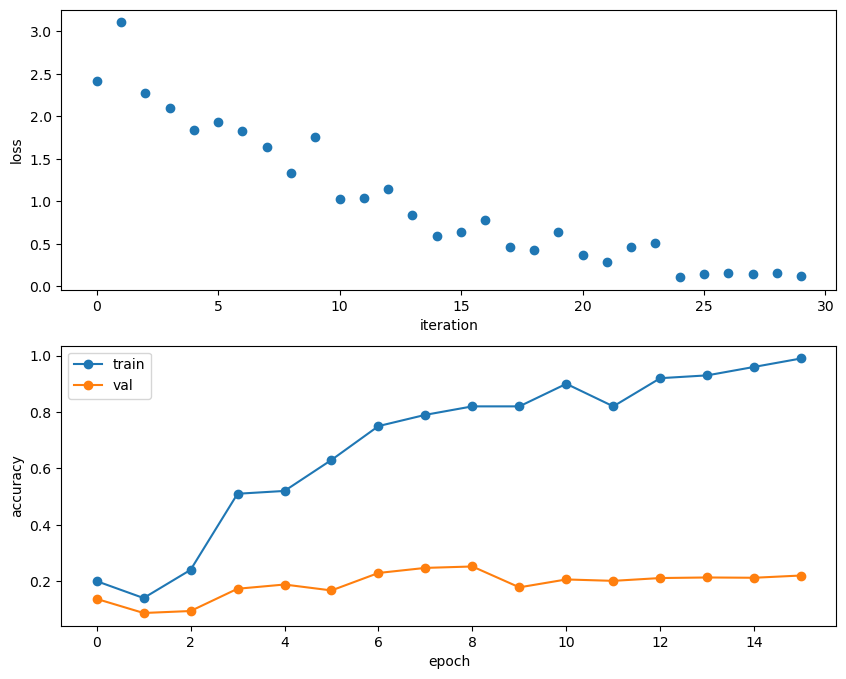

In [25]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the Network
Training the three-layer convolutional network for one epoch

In [26]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(
    model,
    data,
    num_epochs=1,
    batch_size=50,
    update_rule='adam',
    optim_config={'learning_rate': 1e-3,},
    verbose=True,
    print_every=20
)
solver.train()

(Iteration 1 / 980) loss: 2.304740
(Epoch 0 / 1) train acc: 0.103000; val_acc: 0.107000
(Iteration 21 / 980) loss: 2.098229
(Iteration 41 / 980) loss: 1.949788
(Iteration 61 / 980) loss: 1.888398
(Iteration 81 / 980) loss: 1.877093
(Iteration 101 / 980) loss: 1.851877
(Iteration 121 / 980) loss: 1.859353
(Iteration 141 / 980) loss: 1.800181
(Iteration 161 / 980) loss: 2.143292
(Iteration 181 / 980) loss: 1.830573
(Iteration 201 / 980) loss: 2.037280
(Iteration 221 / 980) loss: 2.020304
(Iteration 241 / 980) loss: 1.823728
(Iteration 261 / 980) loss: 1.692679
(Iteration 281 / 980) loss: 1.882594
(Iteration 301 / 980) loss: 1.798261
(Iteration 321 / 980) loss: 1.851960
(Iteration 341 / 980) loss: 1.716323
(Iteration 361 / 980) loss: 1.897655
(Iteration 381 / 980) loss: 1.319744
(Iteration 401 / 980) loss: 1.738790
(Iteration 421 / 980) loss: 1.488866
(Iteration 441 / 980) loss: 1.718409
(Iteration 461 / 980) loss: 1.744440
(Iteration 481 / 980) loss: 1.605460
(Iteration 501 / 980) loss: 

In [27]:
# Print final training accuracy.
print(
    "Full data training accuracy:",
    solver.check_accuracy(data['X_train'], data['y_train'])
)

Full data training accuracy: 0.4761836734693878


In [28]:
# Print final validation accuracy.
print(
    "Full data validation accuracy:",
    solver.check_accuracy(data['X_val'], data['y_val'])
)

Full data validation accuracy: 0.499


# Spatial Batch Normalization
Spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over the minibatch dimension `N` as well the spatial dimensions `H` and `W`.

### Spatial Batch Normalization: Forward Pass

In [29]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization.
N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  shape: ', x.shape)
print('  means: ', x.mean(axis=(0, 2, 3)))
print('  stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  shape: ', out.shape)
print('  means: ', out.mean(axis=(0, 2, 3)))
print('  stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  shape: ', out.shape)
print('  means: ', out.mean(axis=(0, 2, 3)))
print('  stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  shape:  (2, 3, 4, 5)
  means:  [9.33463814 8.90909116 9.11056338]
  stds:  [3.61447857 3.19347686 3.5168142 ]
After spatial batch normalization:
  shape:  (2, 3, 4, 5)
  means:  [ 6.18949336e-16  5.99520433e-16 -1.22124533e-16]
  stds:  [0.99999962 0.99999951 0.9999996 ]
After spatial batch normalization (nontrivial gamma, beta):
  shape:  (2, 3, 4, 5)
  means:  [6. 7. 8.]
  stds:  [2.99999885 3.99999804 4.99999798]


In [30]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [-0.08034406  0.07562881  0.05716371  0.04378383]
  stds:  [0.96718744 1.0299714  1.02887624 1.00585577]


### Spatial Batch Normalization: Backward Pass

In [31]:
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

#You should expect errors of magnitudes between 1e-12~1e-06
_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  2.786648193872555e-07
dgamma error:  7.0974817113608705e-12
dbeta error:  3.275608725278405e-12


# Spatial Group Normalization
In contrast to Layer Normalization, where you normalize over the entire feature per-datapoint, we do splitting of each per-datapoint feature into G groups and a per-group per-datapoint normalization. 

<p align="center">
<img src="https://raw.githubusercontent.com/cs231n/cs231n.github.io/master/assets/a2/normalization.png">
</p>
<center>Visual comparison of the normalization techniques discussed so far (image edited from paper below)</center>

[Wu, Yuxin, and Kaiming He. "Group Normalization." arXiv preprint arXiv:1803.08494 (2018).](https://arxiv.org/abs/1803.08494)

### Spatial Group Normalization: Forward Pass

In [32]:
np.random.seed(231)

# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization.
N, C, H, W = 2, 6, 4, 5
G = 2
x = 4 * np.random.randn(N, C, H, W) + 10
x_g = x.reshape((N*G,-1))
print('Before spatial group normalization:')
print('  shape: ', x.shape)
print('  means: ', x_g.mean(axis=1))
print('  stds: ', x_g.std(axis=1))

# Means should be close to zero and stds close to one
gamma, beta = np.ones((1,C,1,1)), np.zeros((1,C,1,1))
bn_param = {'mode': 'train'}

out, _ = spatial_groupnorm_forward(x, gamma, beta, G, bn_param)
out_g = out.reshape((N*G,-1))
print('After spatial group normalization:')
print('  shape: ', out.shape)
print('  means: ', out_g.mean(axis=1))
print('  stds: ', out_g.std(axis=1))

Before spatial group normalization:
  shape:  (2, 6, 4, 5)
  means:  [9.72505327 8.51114185 8.9147544  9.43448077]
  stds:  [3.67070958 3.09892597 4.27043622 3.97521327]
After spatial group normalization:
  shape:  (2, 6, 4, 5)
  means:  [-2.14643118e-16  5.25505565e-16  2.65528340e-16 -3.38618023e-16]
  stds:  [0.99999963 0.99999948 0.99999973 0.99999968]


# Spatial Group Normalization: Backward Pass

In [33]:
np.random.seed(231)
N, C, H, W = 2, 6, 4, 5
G = 2
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(1,C,1,1)
beta = np.random.randn(1,C,1,1)
dout = np.random.randn(N, C, H, W)

gn_param = {}
fx = lambda x: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]
fg = lambda a: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]
fb = lambda b: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_groupnorm_forward(x, gamma, beta, G, gn_param)
dx, dgamma, dbeta = spatial_groupnorm_backward(dout, cache)

# You should expect errors of magnitudes between 1e-12 and 1e-07. 
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  7.413109437563619e-08
dgamma error:  9.468195772749234e-12
dbeta error:  3.354494437653335e-12
